### Nome dos integrantes: Ana Gabriela Gomes de Almeida Ferreira e Lucas Cunha de Souza
### Disciplina: Inteligência Artificial
### Professor: Sérgio Nery Simões

# Solução de Problemas de Otimização

Este documento tem como objetivo apresentar, discutir e comparar o desempenho de algoritmos para o Problema das 8 rainhas (8-queens Problem). Os algoritmos que serão comparados são:

- [HC-R] – Hill-Climbing with Restart
- [SA] – Simulated Annealing.
- [GA] – Genetic Algorithm.

Devemos importar as bibliotecas utilizadas para as funções auxiliares.

In [36]:
import random
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import clear_output

Após importarmos as bibliotecas, vamos começar a apresentar as funções auxiliares genéricas aos algoritmos.

In [37]:
# Cria uma solucao inicial com as rainhas em um ordem aleatoria
def solucao_aleatoria():
    return random.sample(range(1,9), 8)

In [38]:
# Função que recebe um Vetor-Tabuleiro e retorna o 
# número de pares de rainhas se atacando mutuamente nas linhas.
def conta_ataques_linhas(VT):

    ataques = 0
    N = len(VT)
    for col1 in range(N):
        lin1 = VT[col1]
        for col2 in range(col1+1, N):
            lin2 = VT[col2]
            if lin1==lin2:
                ataques +=1

    return ataques

In [39]:
# Função que recebe um Vetor-Tabuleiro e retorna o número de pares 
# de rainhas se atacando mutuamente nas diagonais.
def conta_ataques_diagonais(VT):
    
    ataques = 0
    N = len(VT)

    for col1 in range(N):
        lin1 = VT[col1]
        for col2 in range(col1+1, N):
            lin2 = VT[col2]

            # diferenças entre as linhas e colunas
            d1 = lin1-col1
            d2 = lin2-col2

            # somas das linhas e colunas
            s1 = lin1+col1
            s2 = lin2+col2

            # condições para ataques nas diagonais
            if d1==d2 or s1==s2:
                ataques +=1

    return ataques

In [40]:
# Função que recebe um Vetor-Tabuleiro e retorna o número de 
# pares de rainhas se atacando mutuamente nas linhas e diagonais.

# função-objetivo o número de pares de rainhas se atacando
def conta_ataques(VT):
    ataques  = conta_ataques_linhas(VT)
    ataques += conta_ataques_diagonais(VT)

    return ataques

In [41]:
# Gera todos os vizinhos possíveis, variando uma rainha de cada vez.
def gera_vizinhos(VT):

    N = len(VT)
    for col in range(N):
        for lin in range(N):
            # se nao existe rainha naquela linha,
            # entao gera estado vizinho.
            linha = lin+1
            if linha != VT[col]:
                vizinho   = VT.copy()
                vizinho[col] = linha

                yield vizinho

In [42]:
def gera_tuplas_custos(Populacao):
    '''
    Gera tuplas com os custos de todos os individuos da populacao.
    '''
    TuplasCustos = []
    for individuo in Populacao:
        ataques = conta_ataques(individuo)

        TuplasCustos += [(ataques, individuo)]

    return TuplasCustos


In [43]:
# Seleciona melhor vizinho
def obtem_melhor_vizinho(tabuleiro, solucao_inicial):
    #solucao aleatoria que foi criada
    
    #melhor_custo = conta_ataques(solucao_inicial) 
    #melhor_vizinho = solucao_inicial
    #populacao = gera_vizinhos(solucao_inicial)
    
    custo1 = conta_ataques(tabuleiro)
    custo2 = conta_ataques(solucao_inicial)
    
    if custo1 < custo2:
        melhor_custo = custo1
        melhor_vizinho = tabuleiro
    else:
        melhor_custo = custo2
        melhor_vizinho = solucao_inicial        
    
    populacao = gera_vizinhos(melhor_vizinho)
    tuplas = gera_tuplas_custos(populacao)
    vizinhos = sorted(tuplas, key=lambda k: k[0])

    for custo, individuo in vizinhos:
        if custo < melhor_custo:
            melhor_custo = custo
            melhor_vizinho = individuo

    return melhor_vizinho, melhor_custo

Após criarmos as funções auxiliares, vamos começar a apresentar as funções de plotagem utilizadas.

- Plotagem Genérica:

In [44]:
# Plota o tabuleiro

def plota_tabuleiro(positions):
    fig, ax = plt.subplots()
    
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks(range(9))
    ax.set_yticks(range(9))
    ax.grid(True)
    
    for i in range(8):
        for j in range(8):
            if (i + j) % 2 == 0:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=True, color='lightgrey'))
            else:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=True, color='white'))
    
    for col, row in enumerate(positions):
        ax.text(col + 0.5, row - 0.5, '♛', fontsize=30, ha='center', va='center', color='black')
    
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    plt.show()

- Plotagem para o algoritmo SA:

In [45]:
# Plota o gráfico de probabilidade aceitação

def plot_acceptance_prob(iteration_list, accept_p_list):
    fig, ax = plt.subplots()
    x = iteration_list
    y = accept_p_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    # Criar uma nova lista de cores com base nos valores de y
    xc, yc, colors = zip(*[(xi, yi, 'b') if yi==1.0 else (xi, yi, 'r') \
                           for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

In [46]:
# Plota o gráfico de temperatura

def plot_temperature(iteration_list, temperat_list):
    fig, ax = plt.subplots()

    x = iteration_list
    y = temperat_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.plot(x,y)

In [47]:
def plot_custos_sa(lista_iteracoes, lista_conflitos, lista_melhor_conflitos, ax):
        
    x = lista_iteracoes
    y1 = lista_conflitos
    y2 = lista_melhor_conflitos
    
    ax.plot(x,y1, label='Atual')
    ax.plot(x,y2, label='Melhor')
    ax.legend()

    # Adicionar título e labels aos eixos
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Qnt de Ataques (Custos)')
    ax.set_title('Gráfico de Conflitos por Iteração')

    ax.set_xlim([0, len(x)-1])
    
    plt.show()

In [48]:
# Atualiza os gráficos

def plot_axes_figure_sa(lista_iteracoes, lista_aceitacao_prob, lista_temperatura, tabuleiro, lista_conflitos, lista_melhor_conflitos):

    x = lista_iteracoes
    y1 = lista_conflitos
    y2 = lista_melhor_conflitos
    y3 = lista_aceitacao_prob
    y4 = lista_temperatura

    #clear_output(wait=True)

    fig, ((ax1)) = plt.subplots(1, 1, figsize=(6,6))

    plot_custos_sa(x, y1, y2, ax1)
    plot_acceptance_prob(x, y3)
    plot_temperature(x, y4)
    plota_tabuleiro(tabuleiro)

    # Ajusta o espaçamento entre os subgráficos
    fig.tight_layout()

    plt.pause(0.001)

- Plotagem para o algoritmo HC:

In [49]:
# Atualiza os gráficos de custos

def plot_custos(iteration_list, lista_conflitos, ax):
    
    x = iteration_list
    y1 = lista_conflitos
    
    ax.plot(x,y1, label='Atual')
    ax.legend()

    # Adicionar título e labels aos eixos
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Qnt de Ataques (Custos)')
    ax.set_title('Gráfico de Conflitos por Iteração')

    ax.set_xlim([0, len(x)-1])
    
    plt.show()
    

In [50]:
# Atualiza os gráficos

def plot_axes_figure_hc(iteration_list, lista_conflitos, tabuleiro):
    
    x = iteration_list    
    y1 = lista_conflitos
    
    #clear_output(wait=True)

    fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    plot_custos(x, y1, ax1)
    plota_tabuleiro(tabuleiro)
    
    # Ajusta o espaçamento entre os subgráficos
    fig.tight_layout()
    
    plt.pause(0.001)
    
    plt.show()


## Tabuleiro principal

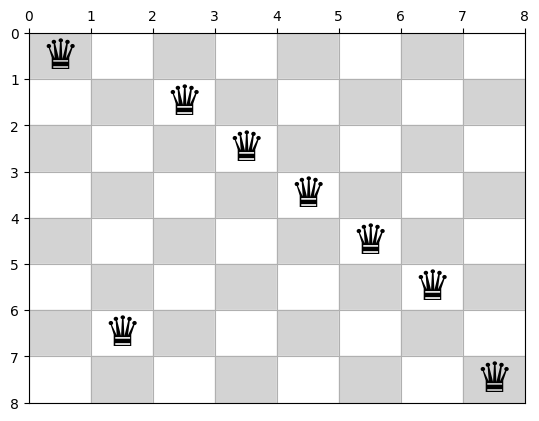

In [51]:
tabuleiro = solucao_aleatoria()
plota_tabuleiro(tabuleiro)

## Algoritmo 01: Hill Climb Restart

In [52]:
# HILL-CLIMBING COM RESTART
def hill_climbing_restart(tabuleiro, param):
    
    #print("Tabuleiro recebido:", tabuleiro)
    lista_tabuleiro = []
    lista_iteracoes = []
    lista_conflitos = []
    
    # Parâmetro: 20 restarts
    for iteracao in range(20):
        # solucao inicial
        solucao_inicial = solucao_aleatoria()

        # melhor solucao ate o momento
        solucao_melhor, custo_melhor = obtem_melhor_vizinho(tabuleiro, solucao_inicial)
        
        while True:
            # tenta obter um candidato melhor
            candidato_atual, custo_atual = obtem_melhor_vizinho(tabuleiro, solucao_melhor)
            # print(custo_melhor, custo_atual)
            if custo_atual < custo_melhor:
                custo_melhor = custo_atual
                solucao_melhor = candidato_atual
            else:
                break   # custo nao melhorou, entao sai do while
        
        lista_tabuleiro += [candidato_atual]
        lista_iteracoes += [iteracao]
        lista_conflitos  += [custo_atual]
        
        #print(f"Iteração {iteracao}, melhor conflito: {custo_melhor}")
    if param == 1:
        plot_axes_figure_hc(lista_iteracoes, lista_conflitos, candidato_atual)
    
    return custo_melhor, solucao_melhor

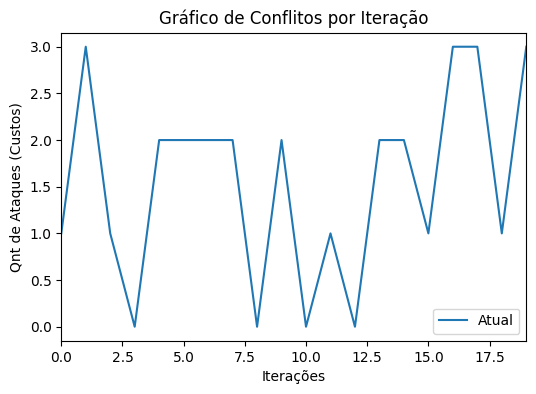

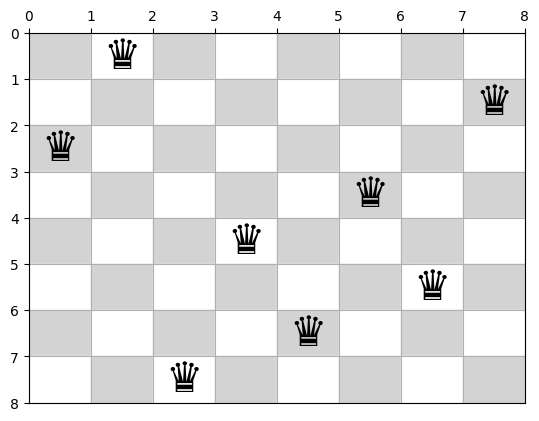

In [53]:

#print("Tabuleiro recebido:", tabuleiro, "com custo:", conta_ataques(tabuleiro))
#plota_tabuleiro(vetorInicial)
param = 1
custo, vetor_melhor = hill_climbing_restart(tabuleiro, param)

#print("Melhor solução:", vetor_melhor, "com custo:", custo)
#plota_tabuleiro(vetor_melhor)

## Algoritmo 02: SA

In [54]:
def probabilidade_aceitacao(conflito_atual, novo_conflito, temperatura):
    '''if novo_conflito < conflito_atual: # melhor == menor (<)
        return 1.0
    else:
        return math.exp((conflito_atual - novo_conflito) / temperatura)'''
        
    variacao = conflito_atual - novo_conflito
    
    if variacao < 0 or random.uniform(0, 1) < np.exp(-variacao / temperatura):
        return 1.0
    else:
        return variacao
    

In [55]:
# nrep: número de vizinhos gerados em cada iteração
#def simulated_annealing(tabuleiro, nrep, iteracoes):
def simulated_annealing(tabuleiro, param):
    decaimento_min = 0.001
    decaimento_max = 0.01
    iteracoes = 1000
    
    tabuleiro_atual = tabuleiro.copy()
    melhor_tabuleiro = tabuleiro_atual.copy()
    
    conflito_atual = conta_ataques(tabuleiro_atual)
    melhor_conflito = conflito_atual
    # Parâmetro: temperatura = 1000
    temperatura = 1000
    
    #-----------------------------------------------------
    lista_iteracoes = []
    lista_melhor_conflitos = []
    lista_conflitos = []
    lista_aceitacao_prob = []
    lista_temperatura = []
    #-----------------------------------------------------
    
    lista_iteracoes.append(0)
    lista_conflitos.append(conflito_atual)
    lista_melhor_conflitos.append(melhor_conflito)
    lista_temperatura.append(temperatura) 
    lista_aceitacao_prob.append(1) 
    
    iteracao = 1    
    
    while (temperatura > 0) and (iteracao < iteracoes):
        
        for _ in range(50):
                
            novo_tabuleiro = solucao_aleatoria()
            novo_conflito = conta_ataques(novo_tabuleiro)
            
            tabuleiro_atual = solucao_aleatoria()
            conflito_atual = conta_ataques(tabuleiro_atual)
            
            tabuleiro_atual, conflito_atual = obtem_melhor_vizinho(tabuleiro_atual, novo_tabuleiro)
            
            variacao = novo_conflito - conflito_atual
            if variacao < 0 or random.uniform(0, 1) < np.exp(-variacao / temperatura):
                aceitacao_prob = np.exp(-variacao / temperatura)
            else:
                aceitacao_prob = 0
                
            if conflito_atual < melhor_conflito:
                melhor_tabuleiro = tabuleiro_atual
                melhor_conflito = conflito_atual

            cooling_rate = random.uniform(decaimento_min, decaimento_max)
            temperatura *= (1 - cooling_rate)

            #----------------------------------------------

            lista_iteracoes.append(iteracao)
            lista_melhor_conflitos.append(melhor_conflito)
            lista_conflitos.append(conflito_atual)
            lista_aceitacao_prob.append(aceitacao_prob)
            lista_temperatura.append(temperatura)
            
            iteracao += 1
            
    #print(f"Iteração {iteracao}, melhor conflito: {melhor_conflito}")
    if param == 1:
        plot_axes_figure_sa(lista_iteracoes, lista_aceitacao_prob, lista_temperatura, melhor_tabuleiro, lista_conflitos, lista_melhor_conflitos)

    return melhor_conflito, melhor_tabuleiro

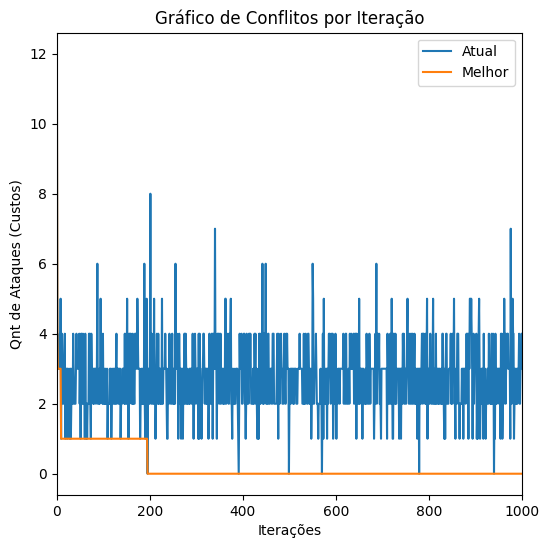

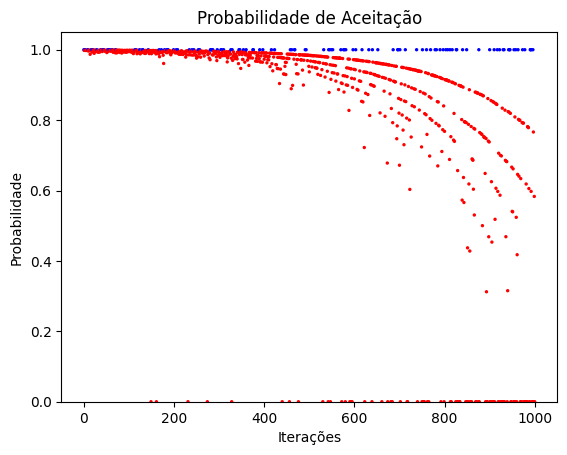

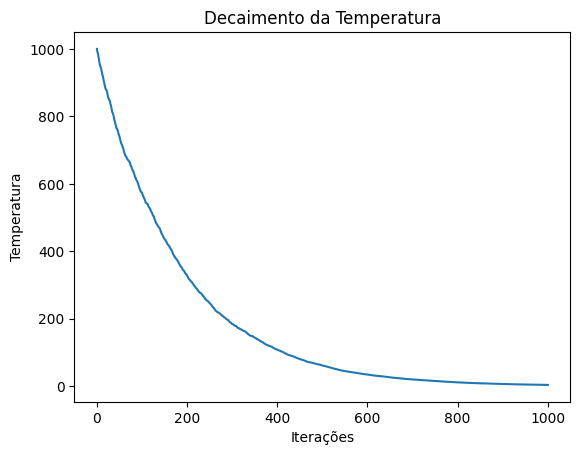

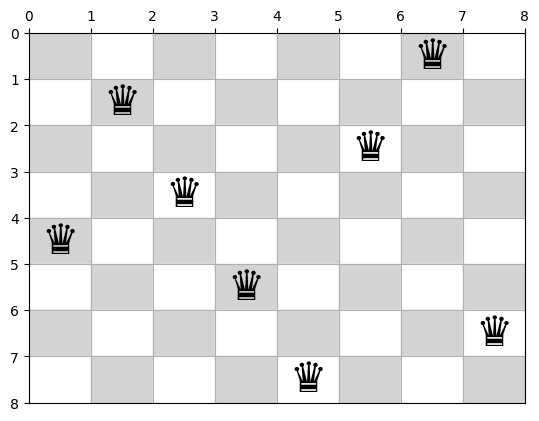

Melhor solução: [5, 2, 4, 6, 8, 3, 1, 7] com custo: 0


In [56]:
#print("Tabuleiro recebido:", tabuleiro, "com custo:", conta_ataques(tabuleiro))
#plota_tabuleiro(tabuleiro)

#nrep = 50
#iteracoes = 1000
param = 1
custo, vetor_melhor = simulated_annealing(tabuleiro, param)

print("Melhor solução:", vetor_melhor, "com custo:", custo)

## Algoritmo 03: Genetic Algorithm

In [57]:
def mutacao(VT, p_mutacao=0.20):

    VT_mutated = VT.copy()

    N = len(VT)
    p = np.random.rand()

    if p < p_mutacao:
        col   = np.random.randint(0,N)    # indice da coluna (base-0)
        linha = np.random.randint(1,N+1)  # valor da linha   (base-1)

        VT_mutated[col] = linha
        #print(col+1, linha)

    return VT_mutated

In [58]:
# Crossover com dois vetores
def crossover2(Parent1, Parent2):

    N = len(Parent1)

    # ponto de corte
    c = np.random.randint(1, N-1)

    # crossover no ponto de corte
    # gerando dois filhos
    child1 = Parent1[:c] + Parent2[c:]      # Python List format
    child2 = Parent2[:c] + Parent1[c:]      # Python List format

    return child1, child2

In [59]:
# SELECAO POR TORNEIO
def selecao(Populacao):
    Candidato1 = random.choice(Populacao)
    Candidato2 = random.choice(Populacao)

    a1 = conta_ataques(Candidato1)
    a2 = conta_ataques(Candidato2)

    # eleito o candidato com menor custo
    eleito = Candidato1 if a1<=a2 else Candidato2

    return eleito

In [60]:
# tam_pop: tamanho da população
def gera_populacao_inicial(tam_pop):

    populacao = []
    for _ in range(tam_pop):
        individuo = solucao_aleatoria()

        populacao.append(individuo)

    return populacao

In [61]:
def fitness(individuo):
    ataques = 0
    n = len(individuo)
    for i in range(n):
        for j in range(i + 1, n):
            if individuo[i] == individuo[j] or abs(individuo[i] - individuo[j]) == abs(i - j):
                ataques += 1
    return ataques

In [62]:
def algoritmo_genetico(tabuleiro, param):
    # Parâmetros: uma população de 20 indivíduos com 50 gerações
    tam_pop = 20
    num_geracoes = 50

    # Gera população inicial
    populacao = gera_populacao_inicial(tam_pop)
    
    #tuplaCusto = gera_tuplas_custos(populacao)
    #print(tuplaCusto, "\n")
    #print(len(tuplaCusto), "\n")
    
    # Executa N gerações
    for geracao in range(num_geracoes):
        nova_populacao = []
        for i in range(int(tam_pop / 2)):

            # Seleciona dois candidatos
            pai1 = selecao(populacao)
            pai2 = selecao(populacao)
            
            filho1, filho2 = crossover2(pai1,pai2)
            
            filho1 = mutacao(filho1)
            filho2 = mutacao(filho2)
            
            nova_populacao.append(filho1)
            nova_populacao.append(filho2)
            
        # Função fitness (conta_ataques): deve avaliar o quão boa é a solução    
        populacao = sorted(populacao + nova_populacao, key=lambda x: conta_ataques(x))[:tam_pop]

        melhor_individuo = populacao[0]
        melhor_fitness = conta_ataques(melhor_individuo)
        
        #print(f'Geração {geracao}: Melhor custo = {melhor_fitness}')
        if melhor_fitness == 0:
            break

    melhor_individuo = populacao[0]
    melhor_fitness = fitness(melhor_individuo)
    
    #print(f'Melhor solução: {melhor_individuo} com custo = {melhor_fitness}')

            #tuplaCusto = gera_tuplas_custos(populacao)
        
        #i = 0
        
    #print(tuplaCusto, "\n")
    #print(len(tuplaCusto), "\n")
    
    return melhor_fitness, melhor_individuo

Melhor solução: [5, 2, 4, 6, 8, 3, 1, 7] com custo: 0


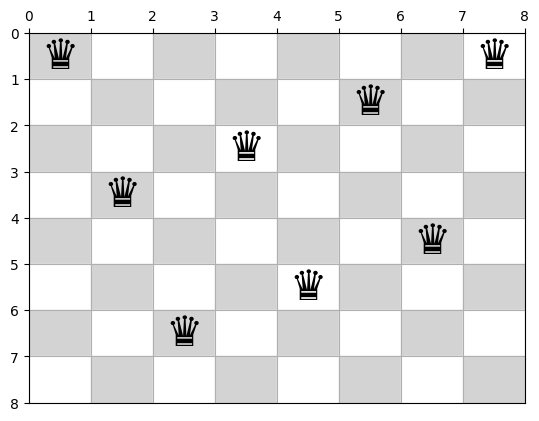

In [63]:
param = 1
melhor_custo, melhor_tabuleiro = algoritmo_genetico(tabuleiro, param)
print("Melhor solução:", vetor_melhor, "com custo:", custo)
plota_tabuleiro(melhor_tabuleiro)

## Estatísticas e comparações

In [64]:
# Dicionario com Nomes dos modelos e suas respectivas variantes
# Tuple: (Algoritmo, Variante): funcao_algoritmo
algoritmos = {
    'HC-R': hill_climbing_restart,
    'SA': simulated_annealing,
    'GA': algoritmo_genetico
}

In [65]:
# Cria estruta de dados (DataFrame) para armazenar vários resultados
# diferentes e visualizá-los através de estatísticas
def cria_df_custos(algoritmos, n_vezes):

    nomes_algoritmos  = algoritmos.keys()

    n_lin = len(nomes_algoritmos)
    n_col = n_vezes

    df_results = pd.DataFrame(np.zeros((n_lin, n_col)),
                              index=nomes_algoritmos)
    df_results.index.name='ALGORITMO'

    return df_results

In [66]:
# Executa N vezes para gerar estatísticas da variável custo
def executa_n_vezes(tabuleiro, algoritmos, n_vezes):

    # Cria DataFrame para armazenar os resultados
    df_custo = cria_df_custos(algoritmos, n_vezes)

    for algoritmo, funcao_algoritmo in algoritmos.items():

        print(algoritmo)

        for i in range(n_vezes):
            param = 0
            custo, solucao = funcao_algoritmo(tabuleiro, param)
            df_custo.loc[algoritmo,i] = custo

            print(f'{custo:10.3f}  {solucao}')

    return df_custo

In [67]:
# numero de vezes que executará cada algoritmo
n_vezes = 30

# Executa N vezes para gerar estatísticas da variável custo
df_custo = executa_n_vezes(tabuleiro, algoritmos, n_vezes)

HC-R
     1.000  [8, 3, 1, 6, 5, 2, 4, 7]
     1.000  [8, 4, 7, 1, 6, 2, 5, 3]
     3.000  [7, 6, 8, 3, 2, 4, 5, 1]
     1.000  [3, 1, 8, 5, 2, 4, 7, 4]
     0.000  [4, 2, 8, 6, 1, 3, 5, 7]
     2.000  [6, 1, 2, 5, 3, 7, 4, 8]
     1.000  [8, 6, 2, 3, 1, 4, 7, 5]
     0.000  [8, 4, 1, 3, 6, 2, 7, 5]
     2.000  [7, 5, 3, 1, 6, 4, 8, 2]
     2.000  [4, 4, 8, 3, 6, 2, 7, 1]
     3.000  [2, 5, 5, 1, 6, 4, 7, 8]
     3.000  [1, 3, 4, 7, 5, 8, 2, 6]
     0.000  [1, 5, 8, 6, 3, 7, 2, 4]
     1.000  [8, 2, 2, 6, 1, 7, 5, 3]
     2.000  [3, 8, 4, 1, 4, 2, 7, 6]
     2.000  [3, 6, 2, 5, 1, 8, 4, 7]
     0.000  [2, 8, 6, 1, 3, 5, 7, 4]
     0.000  [4, 8, 1, 3, 6, 2, 7, 5]
     4.000  [6, 1, 8, 5, 3, 4, 2, 7]
     2.000  [7, 3, 1, 8, 4, 6, 2, 5]
     2.000  [2, 6, 1, 4, 8, 5, 3, 1]
     2.000  [3, 1, 5, 7, 2, 4, 8, 1]
     2.000  [7, 3, 6, 2, 2, 5, 8, 4]
     0.000  [6, 3, 7, 2, 8, 5, 1, 4]
     1.000  [1, 3, 5, 8, 6, 4, 2, 7]
     1.000  [8, 6, 1, 3, 1, 7, 4, 2]
     1.000  [7, 3, 8, 2, 4, 6, 1,

In [68]:
df_custo.T.describe()

ALGORITMO,HC-R,SA,GA
count,30.000000,30.000000,30.000000
mean,1.400000,0.033333,1.000000
std,1.069966,0.182574,0.643268
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000
75%,2.000000,0.000000,1.000000
max,4.000000,1.000000,2.000000


In [69]:
def boxplot_sorted(df, rot=90, figsize=(12,6), fontsize=20):
    df2 = df.T
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(figsize=figsize, rot=rot, fontsize=fontsize,
                                   boxprops=dict(linewidth=4, color='cornflowerblue'),
                                   whiskerprops=dict(linewidth=4, color='cornflowerblue'),
                                   medianprops=dict(linewidth=4, color='firebrick'),
                                   capprops=dict(linewidth=4, color='cornflowerblue'),
                                   flierprops=dict(marker='o', markerfacecolor='dimgray',
                                        markersize=12, markeredgecolor='black'),
                                   return_type="axes")

    axes.set_title("Custo dos Algoritmos", fontsize=fontsize)

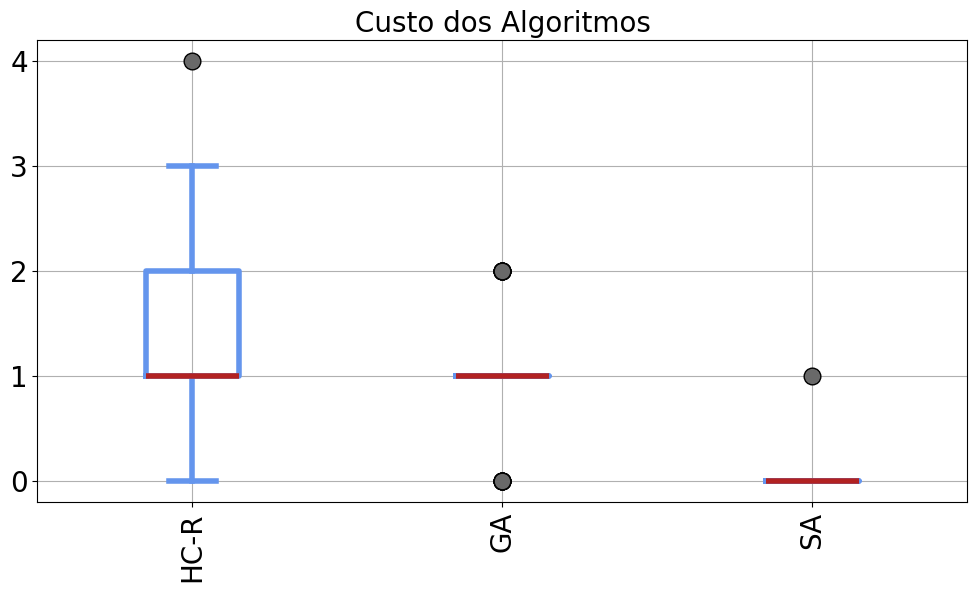

In [70]:
boxplot_sorted(df_custo, rot=90, figsize=(12,6), fontsize=20)